In [2]:
shape_cat="mcal"
vol="vlim"
z_range="all_z"


lambda_range=0
with_r=True

In [3]:
from astropy.io import fits
from astropy.table import Table
import pandas as pd
import fitsio as fio
import numpy as np
import ast

import astropy.cosmology
from astropy.coordinates import SkyCoord  # High-level coordinates
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles
import astropy.units as u
from IPython.display import display, Math
from tqdm.notebook import tqdm
tqdm.pandas()

/home/cz136/anaconda3/envs/balrog/lib/python3.7/site-packages/tqdm/std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [4]:
#This header file contains all the common packages
%matplotlib inline
%run -i /home/cz136/project/sa/lib/src/header.py $shape_cat $vol $z_range 
%run -i /home/cz136/project/sa/lib/src/func.py  
%run -i /home/cz136/project/sa/lib/src/corr_func.py

members= pd.read_pickle("/home/cz136/project/sa/data/BPZ.pkl") #load BPZ catalog
red_members=pd.read_pickle("/home/cz136/project/sa/data/shape_BPZ.pkl")
red_members_index=red_members.index
red_members=None

In [5]:
print("The number of total sources is {}".format(len(members)))
print("The number of red sources is {}".format(len(red_members_index)))

The number of total sources is 34714036
The number of red sources is 105029


In [6]:
NBINS=10

z_bins=np.arange(0.2,0.67,0.15)
lambda_bins=np.append(np.arange(20,66,15),1000)

print(z_bins)
print(lambda_bins)

[0.2  0.35 0.5  0.65]
[  20   35   50   65 1000]


In [7]:
woRedMask=~np.isin(members.index,red_members_index)

In [8]:
print("The number of sources excluding redMaPPer is {}".format(np.sum(woRedMask)))
print("The number of red sources being cut is {}".format(np.sum(~woRedMask)))

The number of sources excluding redMaPPer is 34609603
The number of red sources being cut is 104433


In [9]:
## lambda x z = 4x3
import gc

# def get_ng_values(clusters,members,z_bins_low,z_bins_high,lambda_bins_low,lambda_bins_high,foreback):
#     ng=get_ng_source(clusters,members,z_bins_low,z_bins_high,lambda_bins_low,lambda_bins_high,foreback)
#     ng_values=np.copy(np.array([ng.meanlogr,ng.xi,ng.varxi]))
    
#     del ng
    
#     return(ng_values)
    
ng_matrix=[[None for i in range(4)] for j in range(3)]

for i in trange(3):
    for j in trange(4):
        ng=get_ng_source(clusters,members,z_bins[i],z_bins[i+1],lambda_bins[j],lambda_bins[j+1],foreback="")
        ng_values=np.copy(np.array([ng.meanlogr,ng.xi,ng.varxi]))
        ng_matrix[i][j]=ng_values
        del ng
        gc.collect()

The number of sources is 34714036


/home/cz136/project/sa/lib/src/corr_func.py:162: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  centers=members.loc[center_id]


The number of sources is 34714036
The number of sources is 34714036
The number of sources is 34714036



The number of sources is 34714036
The number of sources is 34714036
The number of sources is 34714036
The number of sources is 34714036



The number of sources is 34714036
The number of sources is 34714036
The number of sources is 34714036
The number of sources is 34714036




In [10]:
## lambda x z = 4x3
ng_wr_matrix=[[None for i in range(4)] for j in range(3)]

for i in trange(4):
    for j in trange(3):
        ng=get_ng_source(clusters,members,z_bins[j],z_bins[j+1],lambda_bins[i],lambda_bins[i+1],woRed=True,foreback="")
        ng_values=np.copy(np.array([ng.meanlogr,ng.xi,ng.varxi]))
        ng_wr_matrix[j][i]=ng_values
        del ng
        gc.collect

The number of sources is 34609603


/home/cz136/project/sa/lib/src/corr_func.py:162: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  centers=members.loc[center_id]


The number of sources is 34609603
The number of sources is 34609603



The number of sources is 34609603
The number of sources is 34609603
The number of sources is 34609603



The number of sources is 34609603
The number of sources is 34609603
The number of sources is 34609603



The number of sources is 34609603
The number of sources is 34609603
The number of sources is 34609603




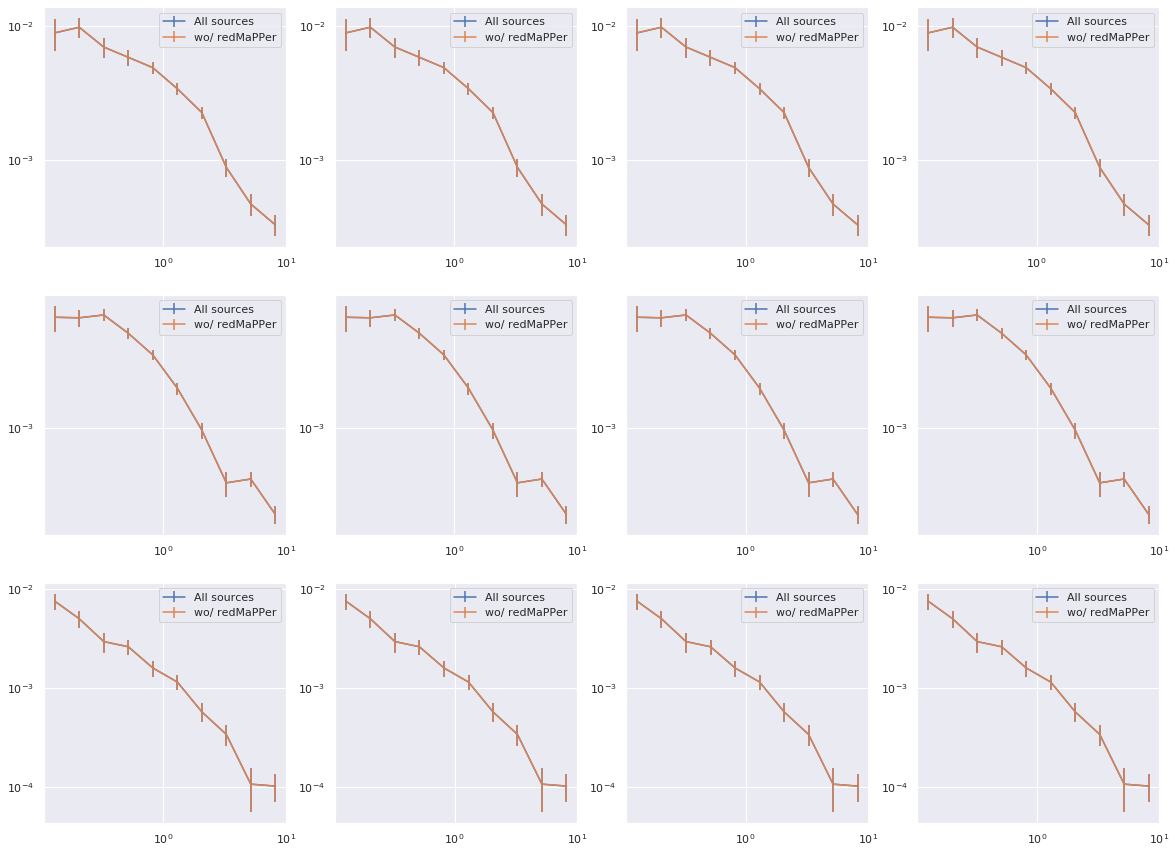

In [11]:
fig, axs = plt.subplots(3, 4,figsize=(20,15))
for i in range(3):
    for j in range(4):
        values=ng_matrix[i][j]
        values_wr=ng_wr_matrix[i][j]
        axs[i,j].errorbar(np.exp(values[0]),values[1],yerr=np.sqrt(values[2]),label="All sources")
        axs[i,j].errorbar(np.exp(values[0]),values_wr[1],yerr=np.sqrt(values_wr[2]),label="wo/ redMaPPer")
        axs[i,j].set_xscale("log")
        axs[i,j].set_yscale("log")
        axs[i,j].legend()
#         axs.xscale("log")
#         axs[i,j].plot(np.exp(values_wr[0]),values_wr[1])

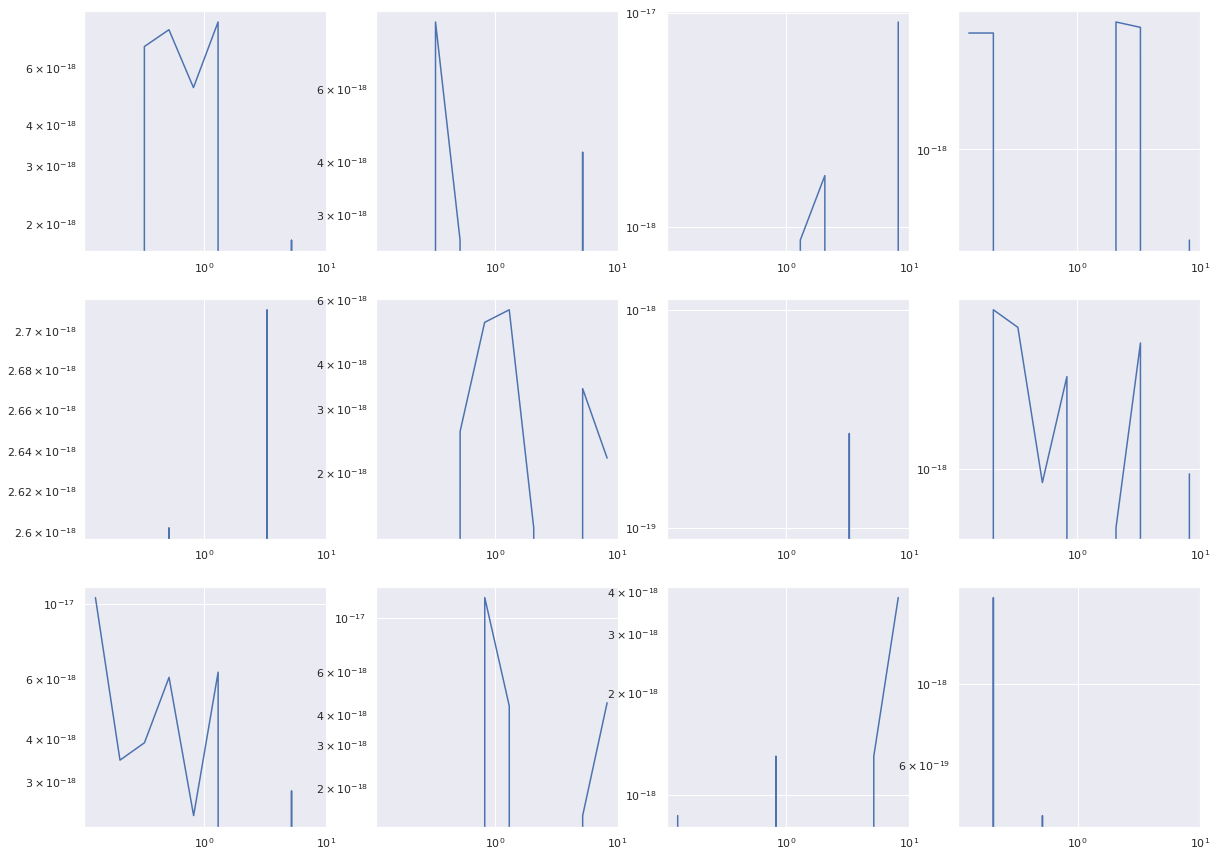

In [12]:
fig, axs = plt.subplots(3, 4,figsize=(20,15))
for i in range(3):
    for j in range(4):
        values=ng_matrix[i][j]
        values_wr=ng_wr_matrix[i][j]
        axs[i,j].plot(np.exp(values[0]),values[1]-values_wr[1])
        axs[i,j].set_xscale("log")
        axs[i,j].set_yscale("log")